![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

# Destination Earth - AVHRR Level 1B Metop Global - Data Access using DEDL HDA

The Advanced Very High Resolution Radiometer (AVHRR) operates at 5 different channels simultaneously in the visible and infrared bands. Channel 3 switches between 3a and 3b for daytime and nighttime. As a high-resolution imager (about 1.1 km near nadir) its main purpose is to provide cloud and surface information such as cloud coverage, cloud top temperature, surface temperature over land and sea, and vegetation or snow/ice. 

[DestinE Data Lake HDA](https://hda.data.destination-earth.eu/ui/dataset/EO.EUM.DAT.METOP.AVHRRL1)

[AVHRR Level 1B - Metop - Global](https://navigator.eumetsat.int/product/EO:EUM:DAT:METOP:AVHRRL1)

## Authenticate on DESP

In [1]:
import destinelab as deauth

In [2]:
import requests
import json
import os
from getpass import getpass

In [3]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


##  Search Metop AVHRR data

In [4]:
search_response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
        "BBox":  [-5 ,31,20,51],
    "collections": ["EO.EUM.DAT.METOP.AVHRRL1"],
    "datetime": "2024-07-04T07:00:00Z/2024-07-10T00:00:00Z"
})


The first item in the search results

In [5]:
from IPython.display import JSON

JSON(search_response.json()["features"][0])

<IPython.core.display.JSON object>

### Download Metop AVHRR data 
We can download now some of the returned data

In [6]:
from tqdm import tqdm
import time
import zipfile

# Define a list of assets to download
for i in range(0,10,2):
    product=search_response.json()["features"][i]
    download_url = product["assets"]["downloadLink"]["href"]
    print(download_url)
    filename = "downloadLink"
    response = requests.get(download_url, headers=auth_headers)
    total_size = int(response.headers.get("content-length", 0))

    print(f"downloading {filename}")

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
        
    zf=zipfile.ZipFile(filename)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')

https://hda.data.destination-earth.eu/stac/collections/EO.EUM.DAT.METOP.AVHRRL1/items/AVHR_xxx_1B_M01_20240704053103Z_20240704071303Z_N_O_20240704062150Z/download?provider=eumetsat
downloading downloadLink


100%|██████████| 477M/477M [00:01<00:00, 369MB/s] 


https://hda.data.destination-earth.eu/stac/collections/EO.EUM.DAT.METOP.AVHRRL1/items/AVHR_xxx_1B_M01_20240704071303Z_20240704085503Z_N_O_20240704080237Z/download?provider=eumetsat
downloading downloadLink


100%|██████████| 478M/478M [00:01<00:00, 311MB/s] 


https://hda.data.destination-earth.eu/stac/collections/EO.EUM.DAT.METOP.AVHRRL1/items/AVHR_xxx_1B_M01_20240704085503Z_20240704103703Z_N_O_20240704094454Z/download?provider=eumetsat


KeyboardInterrupt: 

## Satpy

The Python package satpy supports reading and loading data from many input files. 
For Metop data in the native format, we can use the satpy reader 'avhrr_l1b_eps'.

In [ ]:
pip install --quiet satpy pyspectral

In [ ]:
import os
import zipfile
from glob import glob

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.axes import Axes

from satpy.scene import Scene
from satpy.composites import GenericCompositor
from satpy.writers import to_image
from satpy.resample import get_area_def
from satpy import available_readers
from satpy import MultiScene

import pyresample
import pyspectral

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

### Read and load data

#### Single scene
We can use the Scene constructor from the satpy library, a Scene object represents a single geographic region of data.
Once loaded we can list all the available bands (spectral channel) for that scene.

In [ ]:
filenames = glob('./AVHR_xxx_1B_M0*.nat')
#len(filenames)

In [12]:
# read the last file in filenames
scn = Scene(reader='avhrr_l1b_eps', filenames=[filenames[-1]])
# print available datasets
scn.available_dataset_names()

['1',
 '2',
 '3a',
 '3b',
 '4',
 '5',
 'cloud_flags',
 'latitude',
 'longitude',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'solar_azimuth_angle',
 'solar_zenith_angle']

We can then load the first and the second spectral channels and have a look to some info

In [13]:
# load  
scn.load(['1','2'])
scn['1']

<xarray.DataArray 'truediv-f151f8a7e9a75fc93217fb259c5b53f2' (y: 36720, x: 2048)>
dask.array<truediv, shape=(36720, 2048), dtype=float64, chunksize=(8192, 2048), chunktype=numpy.ndarray>
Coordinates:
    crs      object +proj=longlat +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes: (12/17)
    platform_name:        Metop-B
    sensor:               avhrr-3
    units:                %
    name:                 1
    wavelength:           0.63 µm (0.58-0.68 µm)
    resolution:           1050
    ...                   ...
    start_time:           2024-07-04 12:16:03
    end_time:             2024-07-04 13:58:03
    reader:               avhrr_l1b_eps
    area:                 Shape: (36720, 2048)\nLons: <xarray.DataArray 'from...
    _satpy_id:            DataID(name='1', wavelength=WavelengthRange(min=0.5...
    ancillary_variables:  []

In [14]:
scn['1'].attrs['wavelength']

WavelengthRange(min=0.58, central=0.63, max=0.68, unit='µm')

In [15]:
del scn

#### Multiscene
Another way to read data with satpy is to use the MultiScene class to help with operations that you might want to do on multiple Scene objects at once. 

In [16]:
# read the files
mscn = MultiScene.from_files(filenames, reader='avhrr_l1b_eps')
mscn.load(['1'])

### Visualize single data and blended data


#### Visualize a single data combining bands
The Satpy function *available_composite_ids()*  returns a list of available composite IDs. 

In [17]:
scn = Scene(reader='avhrr_l1b_eps', filenames=[filenames[3]])
scn.available_composite_ids()

[DataID(name='cloud_phase_distinction'),
 DataID(name='cloud_phase_distinction_raw'),
 DataID(name='cloudtop'),
 DataID(name='day_essl_colorized_low_level_moisture'),
 DataID(name='day_essl_low_level_moisture'),
 DataID(name='day_microphysics'),
 DataID(name='essl_colorized_low_level_moisture'),
 DataID(name='essl_low_level_moisture'),
 DataID(name='green_snow'),
 DataID(name='ir108_3d'),
 DataID(name='ir_cloud_day'),
 DataID(name='natural_color'),
 DataID(name='natural_color_raw'),
 DataID(name='natural_enh'),
 DataID(name='natural_with_night_fog'),
 DataID(name='night_fog'),
 DataID(name='night_microphysics'),
 DataID(name='overview'),
 DataID(name='overview_raw'),
 DataID(name='snow')]

In [18]:
composite_id = ["natural_color"]
scn.load(composite_id)

##### Resampling the data
We now resample the data to an area covering Europe


In [19]:
newscn = scn.resample('euro4')

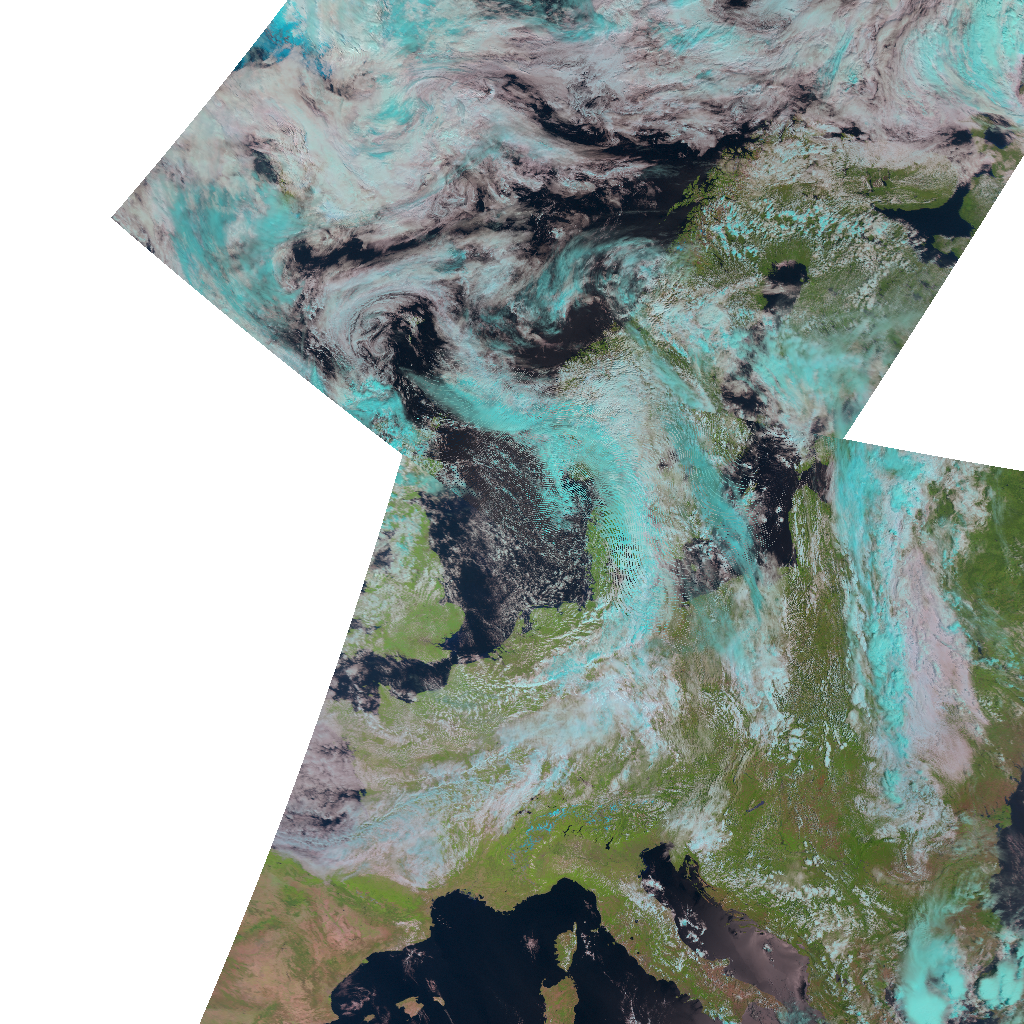

In [20]:
newscn.show("natural_color")

In [21]:
del scn
del newscn

### Visualize blended data
We can use the MultiScene.blend method to combine the Scenes together in to one new Scene. 

In [22]:
new_mscn = mscn.resample('worldeqc30km70')

In [23]:
blended_scn = new_mscn.blend()

Now we have a normal Scene object that we're used to working with. Let's plot it.

Note: This can take a couple minutes to finish.

[########################################] | 100% Completed | 321.19 s
CPU times: user 3min 23s, sys: 55.4 s, total: 4min 18s
Wall time: 5min 21s


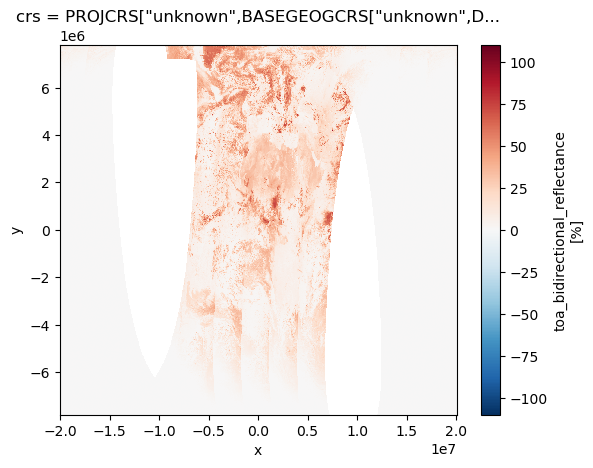

In [24]:
%%time
%matplotlib inline

from dask.diagnostics import ProgressBar
with ProgressBar():
    blended_scn['1'].plot.imshow()

In [25]:
del mscn
del new_mscn
del blended_scn